# Import

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import sys
sys.path.append("../src")
from utils import eval_on_features

In [19]:
air_reserve = pd.read_csv('../data/raw/air_reserve.csv')
air_store_info = pd.read_csv('../data/raw/air_store_info.csv')
air_visit_data = pd.read_csv('../data/raw/air_visit_data.csv')
date_info = pd.read_csv('../data/raw/date_info.csv')
hpg_reserve = pd.read_csv('../data/raw/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../data/raw/hpg_store_info.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
hpg_air_store_id_relation = pd.read_csv('../data/raw/store_id_relation.csv')

datasets = {
    'air_reserve': air_reserve,
    'air_store_info': air_store_info,
    'air_visit_data': air_visit_data,
    'date_info': date_info,
    'hpg_reserve': hpg_reserve,
    'hpg_store_info': hpg_store_info,
    'sample_submission': sample_submission,
    'hpg_air_store_id_relation': hpg_air_store_id_relation
}


for name, df in datasets.items():
    for col in df.columns:
        if df[col].dtype == "object" and ("date" in col.lower() or "time" in col.lower()):
            df[col] = pd.to_datetime(df[col], errors="coerce")

air_visit_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


# Feature Engineering and ML Modelling

## Visit by Reservation and Holiday Features

In [20]:
# Ensure datetime
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
date_info["calendar_date"] = pd.to_datetime(date_info["calendar_date"])

# --- 1) Aggregate daily AIR visits ---
air_daily = (
    air_visit_data
    .groupby("visit_date")["visitors"]
    .sum()
    .reset_index()
)

# --- 2) Aggregate daily HPG reservations (convert to 'visitors' style) ---
hpg_daily = (
    hpg_reserve
    .groupby(hpg_reserve["visit_datetime"].dt.date)["reserve_visitors"]
    .sum()
    .reset_index()
    .rename(columns={"visit_datetime": "visit_date", "reserve_visitors": "visitors"})
)

hpg_daily["visit_date"] = pd.to_datetime(hpg_daily["visit_date"])

# --- 3) Combine AIR + HPG into one daily total ---
all_visits = (
    pd.concat([air_daily, hpg_daily], ignore_index=True)
    .groupby("visit_date")["visitors"]
    .sum()
    .reset_index()
    .sort_values("visit_date")
)

# --- 4) Merge with holiday info (optional features) ---
df = all_visits.merge(
    date_info[["calendar_date", "holiday_flg"]].rename(columns={"calendar_date": "visit_date"}),
    on="visit_date", how="left"
)

# --- 5) Add simple calendar features ---
df["holiday_flg"] = df["holiday_flg"].fillna(0).astype(int)
df["visit_month"] = df["visit_date"].dt.month
df["visit_weekday"] = df["visit_date"].dt.dayofweek
df["is_weekend"] = (df["visit_weekday"] >= 5).astype(int)

# --- Define cutoff date (second last week of April 2017) ---
cutoff_date = pd.to_datetime("2017-04-22")

# --- Filter df ---
df = df[
    df["visit_date"] <= cutoff_date
].copy()

# Final dataset
df = df.sort_values("visit_date").reset_index(drop=True)
df.head()

,visit_date,visitors,holiday_flg,visit_month,visit_weekday,is_weekend
0,2016-01-01,1526,1,1,4,0
1,2016-01-02,4853,1,1,5,1
2,2016-01-03,5591,1,1,6,1
3,2016-01-04,6160,0,1,0,0
4,2016-01-05,6723,0,1,1,0


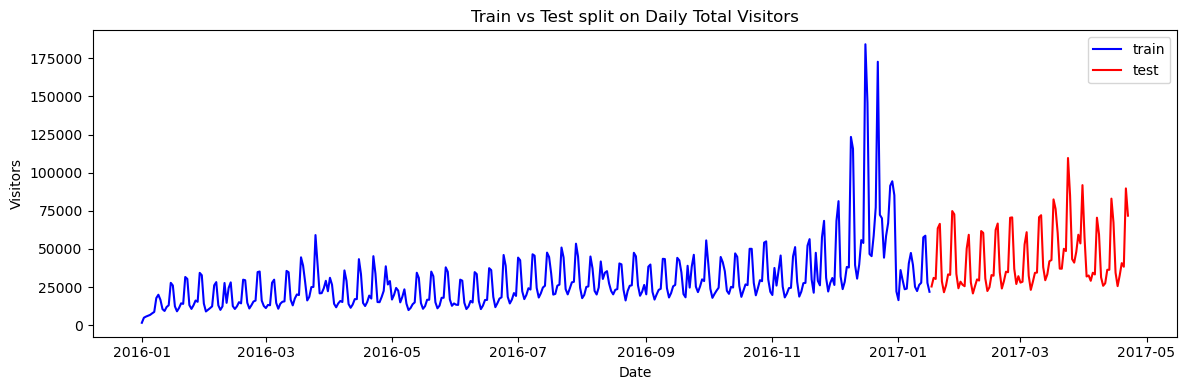

In [21]:
n_train = int(len(df) * 0.8)
X_train = df[:n_train]
X_test = df[n_train:]

daily_total = df.groupby("visit_date")["visitors"].sum()

n_train = int(len(daily_total) * 0.8)
train, test = daily_total.iloc[:n_train], daily_total.iloc[n_train:]

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, "b", label="train")
plt.plot(test.index, test.values, "r", label="test")
plt.title("Train vs Test split on Daily Total Visitors")
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
lgbm = LGBMRegressor(n_estimators=300, random_state=0, n_jobs=-1)

# Lag features per store

In [23]:
# --- 1) Aggregate to daily total ---
lags = (
    df.groupby("visit_date")["visitors"]
      .sum()
      .sort_index()
      .reset_index()
)

# --- 2) Create lag features (global, not per store) ---
lag_list = [1, 2, 3, 4, 5, 6, 7, 14, 28, 30, 60]
for lag in lag_list:
    lags[f"visitors_lag{lag}"] = lags["visitors"].shift(lag)

# --- 3) Example output ---
lags.head(15)

,visit_date,visitors,visitors_lag1,visitors_lag2,visitors_lag3,visitors_lag4,visitors_lag5,visitors_lag6,visitors_lag7,visitors_lag14,visitors_lag28,visitors_lag30,visitors_lag60
0,2016-01-01,1526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,4853,1526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,5591,4853.0,1526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,6160,5591.0,4853.0,1526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,6723,6160.0,5591.0,4853.0,1526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-01-06,7744,6723.0,6160.0,5591.0,4853.0,1526.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-01-07,8654,7744.0,6723.0,6160.0,5591.0,4853.0,1526.0,NaN,NaN,NaN,NaN,NaN
7,2016-01-08,17760,8654.0,7744.0,6723.0,6160.0,5591.0,4853.0,1526.0,NaN,NaN,NaN,NaN
8,2016-01-09,19934,17760.0,8654.0,7744.0,6723.0,6160.0,5591.0,4853.0,NaN,NaN,NaN,NaN
9,2016-01-10,16563,19934.0,17760.0,8654.0,7744.0,6723.0,6160.0,5591.0,NaN,NaN,NaN,NaN


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 382, number of used features: 16
[LightGBM] [Info] Start training from score 28707.526178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


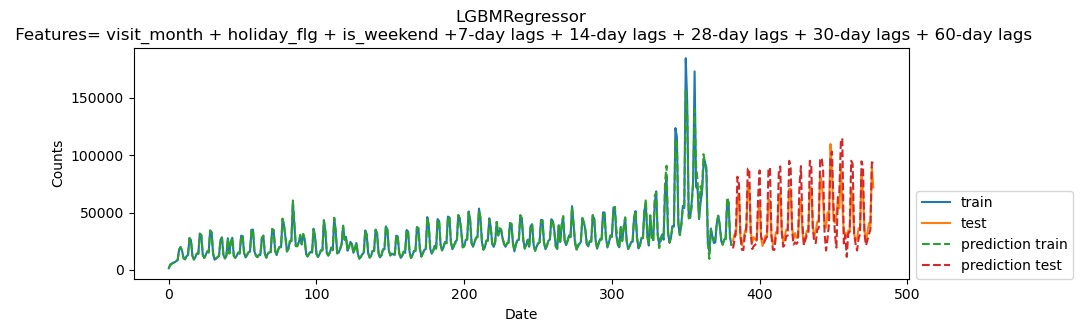

In [24]:
X_lags = pd.merge(df, lags, how="left", on="visit_date")

# Use the correct visitors column for target
y = X_lags["visitors_x"].values

# Exclude datetime columns and the target column from features
X_features = X_lags.drop(columns=[col for col in X_lags.columns if np.issubdtype(X_lags[col].dtype, np.datetime64) or col == "visitors_x"])

eval_on_features(features=X_features, target=y, n_train=n_train, regressor=lgbm,
                 feat_names="visit_month + holiday_flg + is_weekend +7-day lags + 14-day lags + 28-day lags + 30-day lags + 60-day lags", sales_data=True, impute=True)

# Rolling means per store

In [25]:
# First aggregate by date (sum visitors across all stores)
daily_totals = (
    df.groupby("visit_date")["visitors"]
      .sum()
      .sort_index()
)

# Compute rolling means (shifted by 1 day to avoid leakage)
df_daily = pd.DataFrame({
    "visit_date": daily_totals.index,
    "visitors": daily_totals.values
})

df_daily["visitors_ma7"] = df_daily["visitors"].shift(1).rolling(7, min_periods=1).mean()
df_daily["visitors_ma30"] = df_daily["visitors"].shift(1).rolling(30, min_periods=1).mean()
df_daily.head()

,visit_date,visitors,visitors_ma7,visitors_ma30
0,2016-01-01,1526,NaN,NaN
1,2016-01-02,4853,1526.0,1526.0
2,2016-01-03,5591,3189.5,3189.5
3,2016-01-04,6160,3990.0,3990.0
4,2016-01-05,6723,4532.5,4532.5


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1944
[LightGBM] [Info] Number of data points in the train set: 382, number of used features: 19
[LightGBM] [Info] Start training from score 28707.526178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


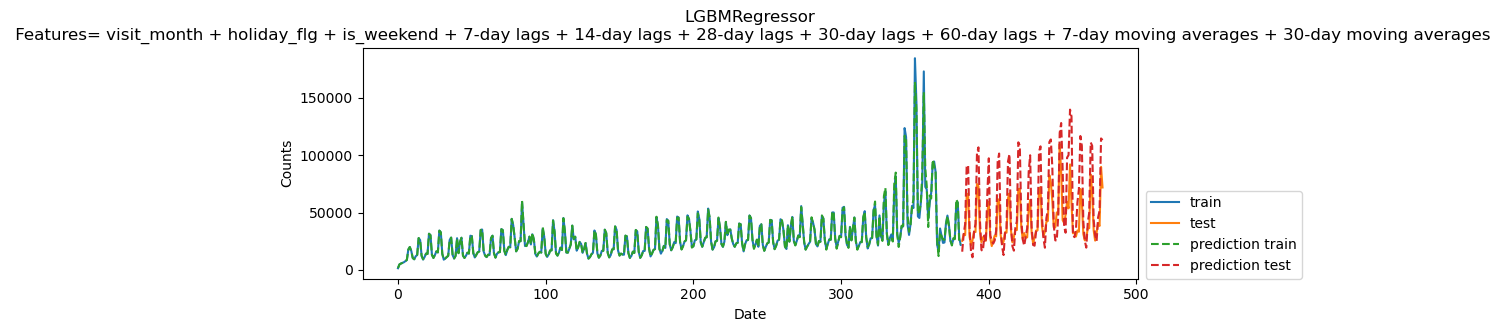

In [26]:
X_rolling_means = pd.merge(X_lags, df_daily[["visit_date", "visitors_ma7", "visitors_ma30"]], on="visit_date", how="left")

# Drop datetime columns before passing to model
X_no_dt = X_rolling_means.drop(columns=[col for col in X_rolling_means.columns if np.issubdtype(X_rolling_means[col].dtype, np.datetime64)])

eval_on_features(features=X_no_dt, target=y, n_train=n_train, regressor=lgbm,
                 feat_names="visit_month + holiday_flg + is_weekend + 7-day lags + 14-day lags + 28-day lags + 30-day lags + 60-day lags + 7-day moving averages + 30-day moving averages", sales_data=True)

## OHE Weekday Names

In [27]:
df["weekday_name"] = df["visit_date"].dt.day_name()
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
weekday_ohe = pd.DataFrame(
    ohe.fit_transform(df[["weekday_name"]]),
    columns=ohe.get_feature_names_out(["weekday_name"]),
    index=df.index
)
df = df.join(weekday_ohe)

df

,visit_date,visitors,holiday_flg,visit_month,visit_weekday,is_weekend,weekday_name,weekday_name_Friday,weekday_name_Monday,weekday_name_Saturday,weekday_name_Sunday,weekday_name_Thursday,weekday_name_Tuesday,weekday_name_Wednesday
0,2016-01-01,1526,1,1,4,0,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,4853,1,1,5,1,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016-01-03,5591,1,1,6,1,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2016-01-04,6160,0,1,0,0,Monday,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-05,6723,0,1,1,0,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,2017-04-18,32570,0,4,1,0,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0
474,2017-04-19,40667,0,4,2,0,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
475,2017-04-20,38294,0,4,3,0,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
476,2017-04-21,89690,0,4,4,0,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 382, number of used features: 24
[LightGBM] [Info] Start training from score 28707.526178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

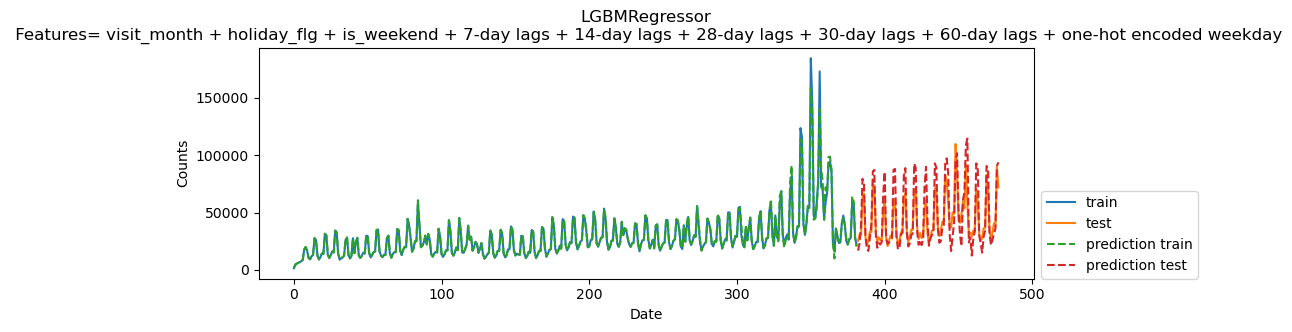

In [28]:
X_ohe_weekday = (
    pd.merge(X_lags, df, on="visit_date", how="left")
    .loc[:, ~pd.merge(X_lags, df, on="visit_date", how="left").columns.duplicated()]
    .drop(columns=["visit_date", "weekday_name"])
)

X_ohe_weekday = X_ohe_weekday.loc[:, ~X_ohe_weekday.columns.str.endswith('_y')]

eval_on_features(features=X_ohe_weekday, target=y, n_train=n_train, regressor=lgbm,
                 feat_names="visit_month + holiday_flg + is_weekend + 7-day lags + 14-day lags + 28-day lags + 30-day lags + 60-day lags + one-hot encoded weekday", sales_data=True)

In [29]:
X_ohe_weekday.columns

Index(['visitors_x', 'holiday_flg_x', 'visit_month_x', 'visit_weekday_x',
       'is_weekend_x', 'visitors_lag1', 'visitors_lag2', 'visitors_lag3',
       'visitors_lag4', 'visitors_lag5', 'visitors_lag6', 'visitors_lag7',
       'visitors_lag14', 'visitors_lag28', 'visitors_lag30', 'visitors_lag60',
       'visitors', 'weekday_name_Friday', 'weekday_name_Monday',
       'weekday_name_Saturday', 'weekday_name_Sunday', 'weekday_name_Thursday',
       'weekday_name_Tuesday', 'weekday_name_Wednesday'],
      dtype='object')

## Model Tuning

In [30]:
X_copy = X_ohe_weekday.copy()

X_copy = X_copy.drop(columns=[col for col in X_ohe_weekday.columns if col in ["weekday_name_Friday", "weekday_name_Thursday", "weekday_name_Wednesday", "weekday_name_Tuesday", "weekday_name_Monday", "weekday_name_Saturday", "weekday_name_Sunday"]])
X_copy["weekday_name"] = df["weekday_name"]

X_copy.columns

Index(['visitors_x', 'holiday_flg_x', 'visit_month_x', 'visit_weekday_x',
       'is_weekend_x', 'visitors_lag1', 'visitors_lag2', 'visitors_lag3',
       'visitors_lag4', 'visitors_lag5', 'visitors_lag6', 'visitors_lag7',
       'visitors_lag14', 'visitors_lag28', 'visitors_lag30', 'visitors_lag60',
       'visitors', 'weekday_name'],
      dtype='object')

In [32]:
y = df["visitors"].values

# Preprocessing: OneHotEncode weekday, passthrough numerics
preproc = ColumnTransformer([
    ("weekday", OneHotEncoder(handle_unknown="ignore"), ["weekday_name"]),
    ("num", "passthrough", [col for col in X_copy.columns if col != "weekday_name"])
])

model = LGBMRegressor(random_state=0, verbose=-1, n_jobs=-1)
pipe = make_pipeline(preproc, model)

param_grid = {
    "lgbmregressor__n_estimators": [400, 600, 800],
    "lgbmregressor__learning_rate": [0.01, 0.05, 0.1],
    "lgbmregressor__num_leaves": [31, 64, 128],
    "lgbmregressor__subsample": [0.6, 0.8, 1.0],
    "lgbmregressor__colsample_bytree": [0.6, 0.8, 1.0],
    "lgbmregressor__min_child_samples": [10, 20, 50]
}

search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=40, cv=TimeSeriesSplit(n_splits=4), random_state=0, n_jobs=-1, verbose=1)
search.fit(X_copy, y)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor wa

,estimator,Pipeline(step...verbose=-1))])
,param_distributions,"{'lgbmregressor__colsample_bytree': [0.6, 0.8, ...], 'lgbmregressor__learning_rate': [0.01, 0.05, ...], 'lgbmregressor__min_child_samples': [10, 20, ...], 'lgbmregressor__n_estimators': [400, 600, ...], ...}"
,n_iter,40
,scoring,None
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan


In [33]:
search.best_score_, search.best_params_

(0.7554577027097286,
 {'lgbmregressor__subsample': 1.0,
  'lgbmregressor__num_leaves': 128,
  'lgbmregressor__n_estimators': 400,
  'lgbmregressor__min_child_samples': 10,
  'lgbmregressor__learning_rate': 0.01,
  'lgbmregressor__colsample_bytree': 0.6})

Train-set R^2: 0.93
Test-set R^2: 0.86


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


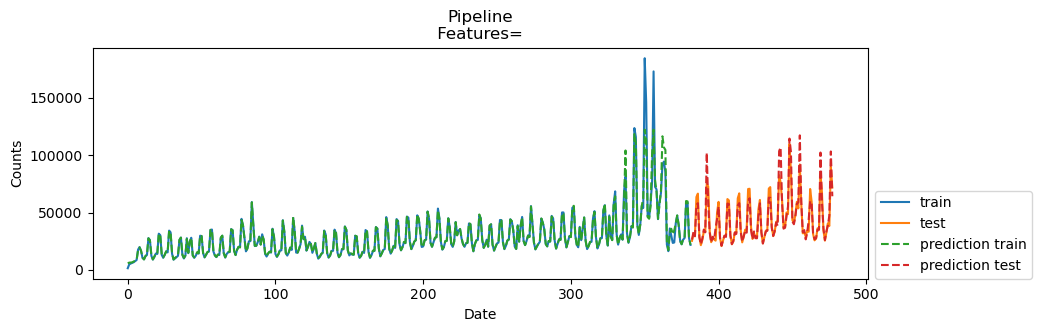

In [34]:
# LightGBM regressor with best hyperparameters
pipe = search.best_estimator_
eval_on_features(features=X_copy, target=y, n_train=n_train, regressor=pipe, sales_data=True, feat_names="", impute=False)